In [21]:
import warnings
warnings.filterwarnings("ignore")

## Importing libraries

In [22]:
import os
import pandas as pd
pd.set_option('display.max_rows',None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import pandas as pd
from sklearn.utils import shuffle

## Importing data

In [23]:
folder = 'images'

In [24]:
df = pd.read_csv('train.csv')

for index, val in enumerate(df['image_id']):
    df.loc[index, 'image_id'] = folder + '/' + val
    
df.sample(10)

,image_id,label
19820,images/699282565.jpg,3
1318,images/1231822734.jpg,1
118,images/102039365.jpg,0
17446,images/4145869943.jpg,4
7294,images/2302696132.jpg,1
15003,images/3694251978.jpg,4
18553,images/471719560.jpg,4
7881,images/2401953205.jpg,3
5338,images/1951683874.jpg,1
16521,images/3969928849.jpg,4


## Data Preprocessing

In [25]:
# Checking for unavailable images

print('length of dataframe :', len(df), '    mumber of images :',len(os.listdir(folder)))

count = 0

for index, rows in tqdm(df.iterrows()):
    if rows['image_id'][7:] not in os.listdir(folder):
        df.drop(index = index, inplace=True)
        count+=1

print("number of rows removed :",count)

df.reset_index(drop=True, inplace=True)

length of dataframe : 21397     mumber of images : 17938


0it [00:00, ?it/s]

21397it [10:37, 33.58it/s]

number of rows removed : 3459


In [26]:
# Creating updated csv
df.to_csv('data.csv', index=False)

In [27]:
# checking shapes of the images

t_set = set()

for index, val in tqdm(enumerate(df['image_id'])):
    img = cv.imread(val)
    t_set.add(img.shape)

len(t_set)

17938it [03:03, 97.91it/s] 


1

## Data visualization

In [62]:
data = pd.read_csv('data.csv')

print('length of dataframe :', len(df), '    mumber of images :',len(os.listdir(folder)))

data.head()

length of dataframe : 43627     mumber of images : 17938


,image_id,label
0,images/157078263.jpg,3
1,images/1574893536.jpg,3
2,images/1575013487.jpg,3
3,images/1576606254.jpg,0
4,images/1579761476.jpg,1


In [63]:
data['label'].value_counts()

label
3    11027
4     2166
2     1993
1     1831
0      921
Name: count, dtype: int64

In [15]:
# augmentation
def random_rotation(image):
    angle = np.random.randint(-10, 10)
    rows, cols, _ = image.shape
    M = cv.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv.warpAffine(image, M, (cols, rows))
    return rotated_image

def random_brightness(image):
    brightness = np.random.uniform(0.7, 1.3)
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * brightness
    brightened_image = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return brightened_image

def random_flip(image):
    if np.random.rand() < 0.5:
        flipped_image = cv.flip(image, 1)  
    else:
        flipped_image = image
    return flipped_image

def random_contrast(image):
    contrast = np.random.uniform(0.5, 1.5)
    brightness = np.random.randint(-50, 50)
    contrast_image = cv.addWeighted(image, contrast, image, 0, brightness)
    return contrast_image


def random_augmentation(image):
    image = random_rotation(image)
    image = random_brightness(image)
    image = random_flip(image)
    image = random_contrast(image)
    return image

# Path to the directory containing original images
input_dir = 'images'
# Path to the directory where augmented images will be saved
output_dir = 'augmented_images'

# Make sure the output directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augment images for each class
target_count = 12000
for class_label in tqdm(range(0,5)):
    
    class_images = data[data['label'] == class_label]
    class_images = class_images.sample(frac=1).reset_index(drop=True)  # Shuffle images
    
    class_count = len(class_images)
    images_to_generate = target_count - class_count
    

    # Load and augment images
    for i in tqdm(range(images_to_generate)):
        image_name = class_images.iloc[i % class_count]['image_id']
        image_path = image_name
        original_image = cv.imread(image_path)

        try:
            original_image = cv.imread(image_path)
            if original_image is None:
                print(f"Error: Failed to load image {image_name}.")
                continue
        except Exception as e:
            print(f"Error: Failed to load image {image_name}. Exception: {e}")
            continue
        
        augmented_image = random_augmentation(original_image)

        # Save augmented image
        output_path = os.path.join(output_dir, f'augmented_{class_label}_{i}.jpg')
        cv.imwrite(output_path, augmented_image)

        # Update CSV with new image info
        new_rows = [{'image_id': output_path, 'label': class_label} for _ in range(images_to_generate)]
        new_data = pd.DataFrame(new_rows)
        data = pd.concat([data, new_data], ignore_index=True)

data.to_csv('data.csv', index=False)


In [64]:
print(len(os.listdir('augmented_images')))

for image in tqdm(os.listdir('augmented_images')):
    data.loc[len(data)] = [('augmented_images/' + image), int(image[10])]

32830


100%|██████████| 32830/32830 [01:06<00:00, 495.42it/s]


In [65]:
len(data)

data['label'].value_counts()

label
3    12000
0    12000
1    12000
2    12000
4     2768
Name: count, dtype: int64

In [66]:
data.to_csv('augmented_data.csv', index=False)

In [67]:
data = pd.read_csv('augmented_data.csv')

In [68]:
data.shape

data.tail()

,image_id,label
50763,augmented_images/augmented_4_95.jpg,4
50764,augmented_images/augmented_4_96.jpg,4
50765,augmented_images/augmented_4_97.jpg,4
50766,augmented_images/augmented_4_98.jpg,4
50767,augmented_images/augmented_4_99.jpg,4


In [69]:
data.loc[45000]

image_id    augmented_images/augmented_2_6224.jpg
label                                           2
Name: 45000, dtype: object

In [70]:
data['label'].value_counts()

label
3    12000
0    12000
1    12000
2    12000
4     2768
Name: count, dtype: int64

In [71]:
label_to_disease = ["Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)", "Cassava Green Mottle (CGM)", "Cassava Mosaic Disease (CMD)", "Healthy"]

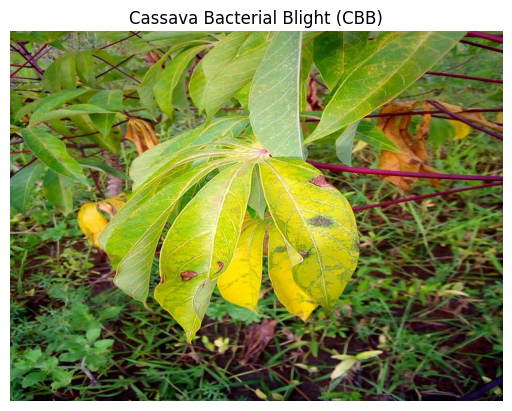

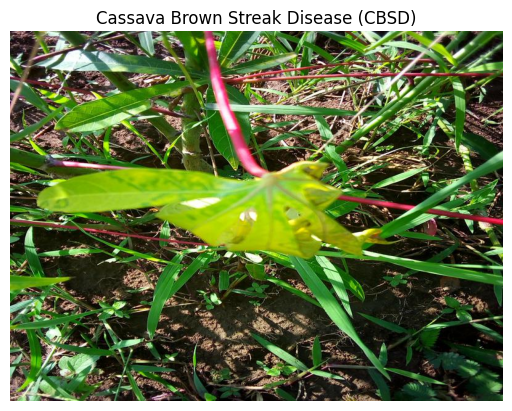

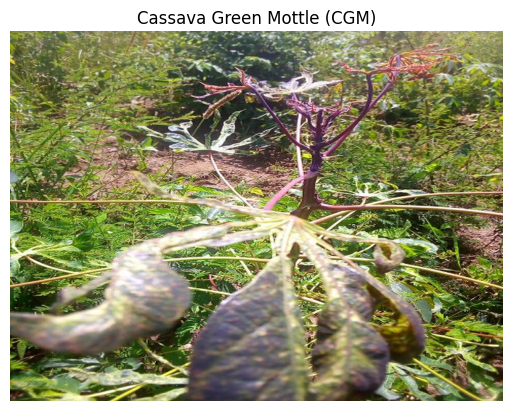

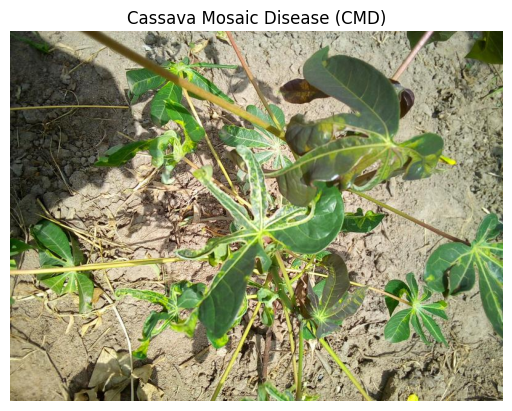

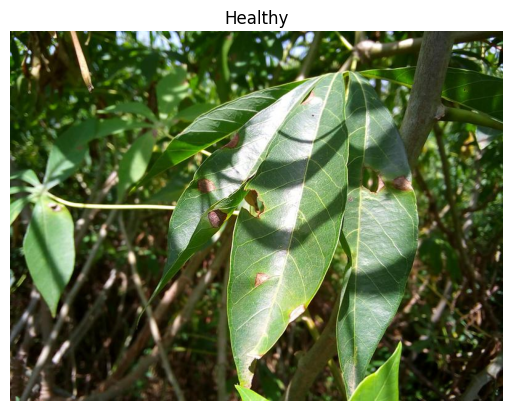

In [72]:
img = [3, 4, 16, 0, 6]

for i in img:
    img = mpimg.imread(df.loc[i, 'image_id'])  
    plt.imshow(img)
    plt.title(label_to_disease[df.loc[i, 'label']])
    plt.axis('off')  
    plt.show()

In [73]:
img = cv.imread(df.loc[0, 'image_id'])
print(img.shape)
print(img)

(600, 800, 3)
[[[ 28  44  33]
  [ 20  36  25]
  [ 18  34  23]
  ...
  [  2  38  26]
  [  3  37  26]
  [  3  37  26]]

 [[ 32  48  37]
  [ 24  40  29]
  [ 20  36  25]
  ...
  [  2  38  26]
  [  3  37  26]
  [  3  37  26]]

 [[ 40  58  45]
  [ 31  49  36]
  [ 25  42  31]
  ...
  [  2  38  26]
  [  3  37  26]
  [  3  37  26]]

 ...

 [[ 71 115 128]
  [ 71 115 128]
  [ 75 117 130]
  ...
  [ 87 112 116]
  [105 130 132]
  [100 125 127]]

 [[ 86 130 143]
  [ 88 132 145]
  [ 89 131 144]
  ...
  [117 139 144]
  [111 136 140]
  [ 96 121 125]]

 [[ 96 140 153]
  [106 150 163]
  [113 152 166]
  ...
  [127 149 154]
  [120 145 149]
  [107 132 136]]]


## Data Processing and Modelling

### CNN

In [ ]:
num_classes = 5


model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(150, 200, 3)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess images
X = []
y = []

target_size = (200, 150)  # Width, Height

for index, row in tqdm(df.iterrows()):
    img = cv.imread(row['image_id'])
    
    # resizing images
    resized_img = cv.resize(img, target_size)

    # min-max normalization
    normalized_image = resized_img / 255.0

    X.append(normalized_image)
    y.append(row['label'])


X = np.array(X)
y = np.array(y)


X = X.reshape(X.shape + (1,))

# Convert labels to one-hot encoded vectors
y = to_categorical(y, num_classes=num_classes)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

17938it [02:28, 120.74it/s]


In [ ]:
# model training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


449/449 [==============================] - 91s 196ms/step - loss: 1.2333 - accuracy: 0.6123 - val_loss: 1.1999 - val_accuracy: 0.6115
Epoch 2/10
449/449 [==============================] - 87s 194ms/step - loss: 1.1874 - accuracy: 0.6155 - val_loss: 1.2013 - val_accuracy: 0.6115
Epoch 3/10
449/449 [==============================] - 87s 195ms/step - loss: 1.1856 - accuracy: 0.6155 - val_loss: 1.1979 - val_accuracy: 0.6115
Epoch 4/10
449/449 [==============================] - 86s 192ms/step - loss: 1.1854 - accuracy: 0.6155 - val_loss: 1.1953 - val_accuracy: 0.6115
Epoch 5/10
449/449 [==============================] - 82s 183ms/step - loss: 1.1845 - accuracy: 0.6155 - val_loss: 1.1930 - val_accuracy: 0.6115
Epoch 6/10
449/449 [==============================] - 85s 188ms/step - loss: 1.1845 - accuracy: 0.6155 - val_loss: 1.1936 - val_accuracy: 0.6115
Epoch 7/10
449/449 [==============================] - 85s 190ms/step - loss: 1.1841 - accuracy: 0.6155 - val_loss: 1.1927 - val_

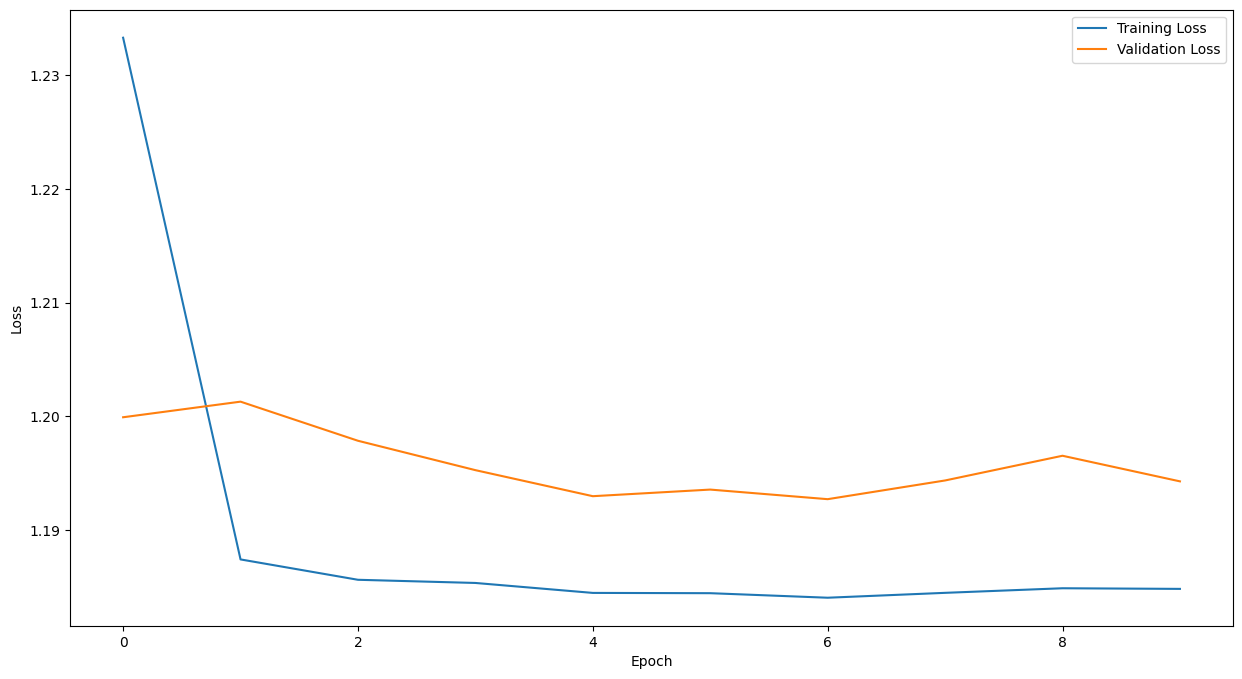

In [ ]:
# Plot training loss and validation loss
plt.figure(figsize=(15,8))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded vectors to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

113/113 [==============================] - 5s 44ms/step - loss: 1.1943 - accuracy: 0.6115
Test Loss: 1.194289207458496
Test Accuracy: 0.6114827394485474
113/113 [==============================] - 5s 45ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       196
           1       0.00      0.00      0.00       385
           2       0.00      0.00      0.00       397
           3       0.61      1.00      0.76      2194
           4       0.00      0.00      0.00       416

    accuracy                           0.61      3588
   macro avg       0.12      0.20      0.15      3588
weighted avg       0.37      0.61      0.46      3588

Confusion Matrix:
[[   0    0    0  196    0]
 [   0    0    0  385    0]
 [   0    0    0  397    0]
 [   0    0    0 2194    0]
 [   0    0    0  416    0]]
